In [1]:
import os
os.environ['KAGGLE_USERNAME'] = "olenamikhailova"

os.environ['KAGGLE_KEY'] = "KGAT_e8b5a4ccb83e496885c5e98432eb4846"

print("Attempting to download BraTS 2020...")
!kaggle datasets download -d awsaf49/brats20-dataset-training-validation --force

print("Unzipping...")
!unzip -q brats20-dataset-training-validation.zip -d ./brats2020
print("Dataset is ready.")

Attempting to download BraTS 2020...
Dataset URL: https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation
License(s): CC0-1.0
 99% 4.14G/4.16G [01:03<00:00, 43.1MB/s]
100% 4.16G/4.16G [01:04<00:00, 69.5MB/s]
Unzipping...
Dataset is ready.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import glob
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

root_search = glob.glob("./brats2020/**/MICCAI_BraTS2020_TrainingData", recursive=True)

if len(root_search) > 0:
    data_root = root_search[0]
    print(f"Dataset root found at: {data_root}")
else:
    data_root = "./brats2020"
    print(f"Assuming root at: {data_root}")

patient_dirs = sorted([d for d in glob.glob(os.path.join(data_root, "*")) if os.path.isdir(d)])
print(f"Total Patient Folders Found: {len(patient_dirs)}")

integrity_report = []

for p_dir in patient_dirs:
    pid = os.path.basename(p_dir)
    flair = glob.glob(os.path.join(p_dir, "*flair.nii"))
    seg = glob.glob(os.path.join(p_dir, "*seg.nii"))

    if not flair or not seg:
        integrity_report.append(pid)

if len(integrity_report) == 0:
    print("INTEGRITY CHECK PASSED: All patients have FLAIR and SEG files.")
else:
    print(f"WARNING: {len(integrity_report)} patients are missing files!")
    print(integrity_report[:5])

csv_files = glob.glob("./brats2020/**/*.csv", recursive=True)

if csv_files:
    print("\n METADATA FOUND ")
    meta_df = pd.read_csv(csv_files[0])
    print(f"Loaded metadata from: {os.path.basename(csv_files[0])}")
    print(meta_df.head())

    if 'Age' in meta_df.columns:
        plt.figure(figsize=(10, 4))
        plt.hist(meta_df['Age'], bins=20, color='teal', edgecolor='black')
        plt.title("Age Distribution in BraTS 2020")
        plt.xlabel("Age")
        plt.ylabel("Count")
        plt.show()
else:
    print("\nNo metadata CSV found (Demographics might be missing in this download).")

Dataset root found at: ./brats2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData
Total Patient Folders Found: 369
['BraTS20_Training_355']

 METADATA FOUND 
Loaded metadata from: name_mapping_validation_data.csv
  BraTS_2017_subject_ID BraTS_2018_subject_ID TCGA_TCIA_subject_ID  \
0   Brats17_CBICA_AAM_1   Brats18_CBICA_AAM_1                  NaN   
1   Brats17_CBICA_ABT_1   Brats18_CBICA_ABT_1                  NaN   
2   Brats17_CBICA_ALA_1   Brats18_CBICA_ALA_1                  NaN   
3   Brats17_CBICA_ALT_1   Brats18_CBICA_ALT_1                  NaN   
4   Brats17_CBICA_ALV_1   Brats18_CBICA_ALV_1                  NaN   

  BraTS_2019_subject_ID   BraTS_2020_subject_ID  
0   BraTS19_CBICA_AAM_1  BraTS20_Validation_001  
1   BraTS19_CBICA_ABT_1  BraTS20_Validation_002  
2   BraTS19_CBICA_ALA_1  BraTS20_Validation_003  
3   BraTS19_CBICA_ALT_1  BraTS20_Validation_004  
4   BraTS19_CBICA_ALV_1  BraTS20_Validation_005  


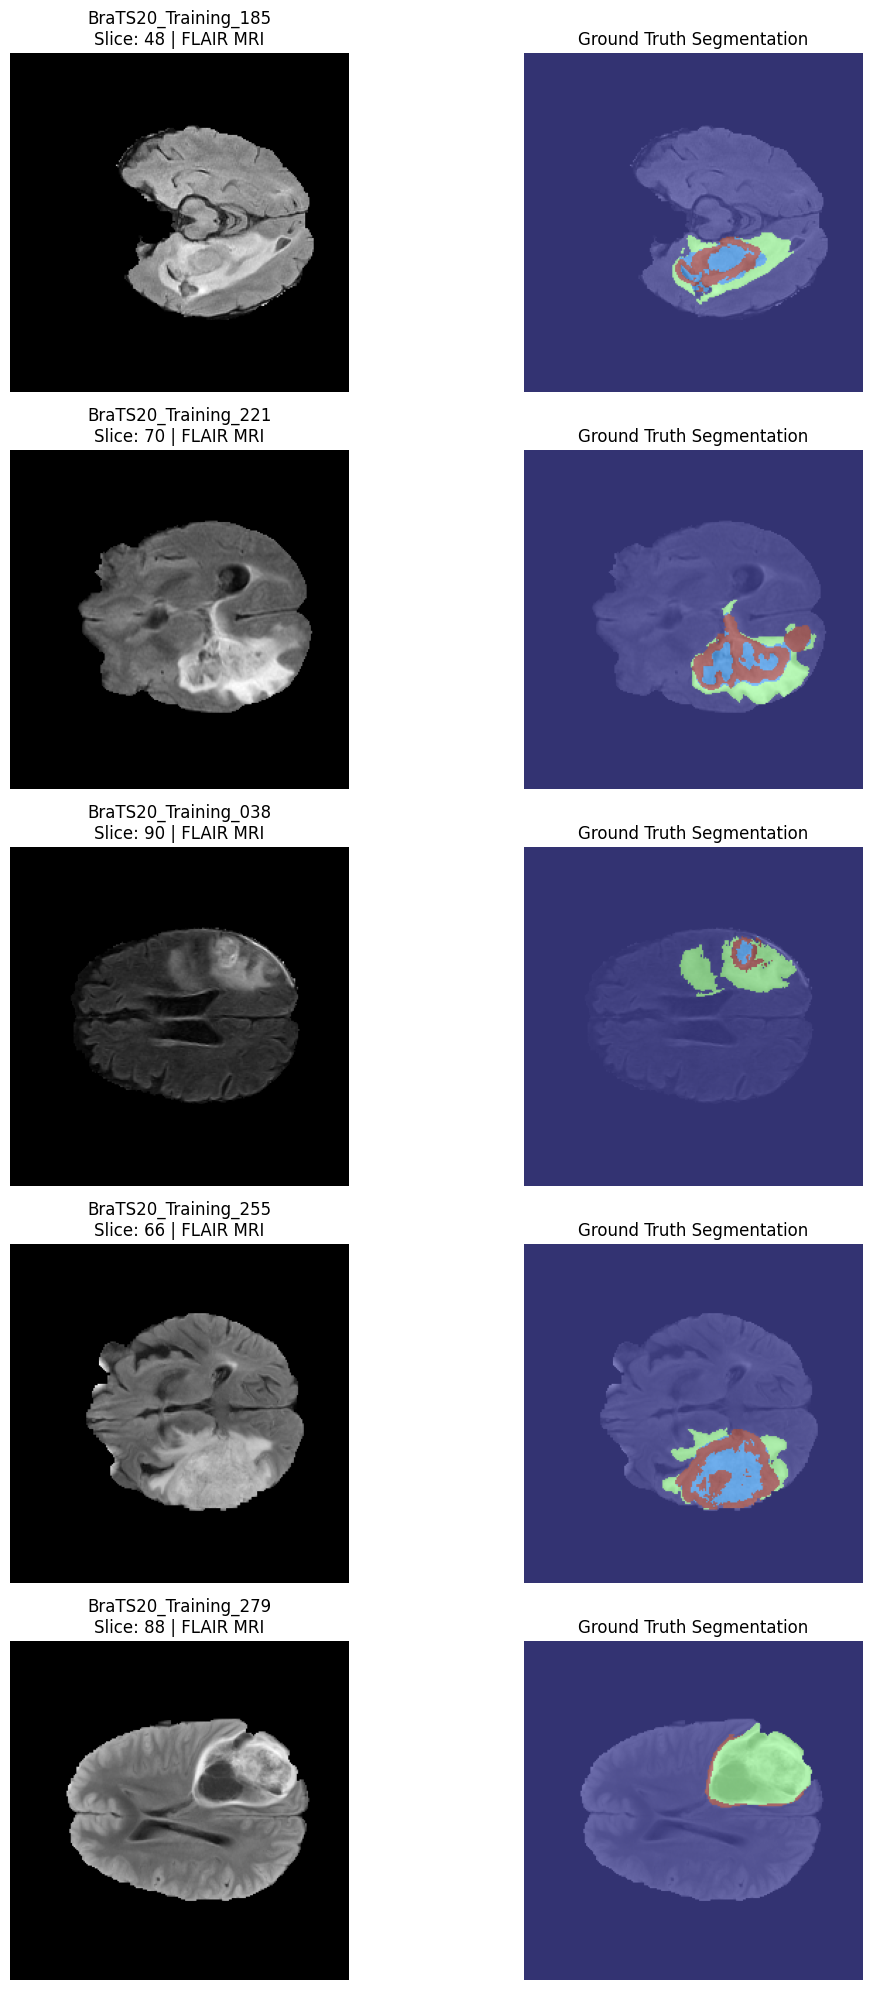

In [4]:
import random

def show_brats_examples(patient_dirs, num_examples=5):
    selected_patients = random.sample(patient_dirs, num_examples)

    plt.figure(figsize=(12, 4 * num_examples))

    for i, p_dir in enumerate(selected_patients):
        pid = os.path.basename(p_dir)

        flair_path = glob.glob(os.path.join(p_dir, "*flair.nii"))[0]
        seg_path = glob.glob(os.path.join(p_dir, "*seg.nii"))[0]

        flair_vol = nib.load(flair_path).get_fdata()
        seg_vol = nib.load(seg_path).get_fdata()

        # We calculate the sum of pixels in the mask to find the slice with the biggest tumor
        # axis=(0, 1) sums up x and y, leaving us with a list of sums for each z-slice
        tumor_counts = np.sum(seg_vol > 0, axis=(0, 1))

        if np.max(tumor_counts) > 0:
            slice_idx = np.argmax(tumor_counts) # Slice with most tumor
        else:
            slice_idx = flair_vol.shape[2] // 2 # Middle slice if no tumor

        # Get the 2D slice
        img_slice = flair_vol[:, :, slice_idx]
        mask_slice = seg_vol[:, :, slice_idx]

        # FLAIR
        plt.subplot(num_examples, 2, i*2 + 1)
        plt.imshow(img_slice, cmap='gray')
        plt.title(f"{pid}\nSlice: {slice_idx} | FLAIR MRI")
        plt.axis('off')

        # MASK
        plt.subplot(num_examples, 2, i*2 + 2)
        plt.imshow(img_slice, cmap='gray', alpha=0.6)
        plt.imshow(mask_slice, cmap='jet', alpha=0.5)
        plt.title(f"Ground Truth Segmentation")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

show_brats_examples(patient_dirs)

In [8]:
import os
import shutil
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

print("CLEANING MISSING DATA:")

root_search = glob.glob("./brats2020/**/MICCAI_BraTS2020_TrainingData", recursive=True)
data_root = root_search[0] if root_search else "./brats2020"

patient_dirs = sorted([d for d in glob.glob(os.path.join(data_root, "*")) if os.path.isdir(d)])
deleted_count = 0

for p_dir in patient_dirs:
    pid = os.path.basename(p_dir)
    flair = glob.glob(os.path.join(p_dir, "*flair.nii"))
    seg = glob.glob(os.path.join(p_dir, "*seg.nii"))

    if not flair or not seg:
        print(f"Deleting Corrupt Patient (Missing files): {pid}")
        shutil.rmtree(p_dir)
        deleted_count += 1

if deleted_count == 0:
    print("No missing values found. Dataset is clean.")
else:
    print(f"Deleted {deleted_count} corrupt patient(s).")


print("\nCHECKING DATASET BALANCE")

csv_files = glob.glob("./brats2020/**/*.csv", recursive=True)

if csv_files:
    df = pd.read_csv(csv_files[0])

    if 'Grade' in df.columns:
        plt.figure(figsize=(6, 4))
        ax = sns.countplot(x='Grade', data=df, palette='viridis')

        plt.title("Dataset Balance: High Grade (HGG) vs Low Grade (LGG)")
        plt.xlabel("Glioma Type")
        plt.ylabel("Count of Patients")

        for p in ax.patches:
            ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')

        plt.show()

        counts = df['Grade'].value_counts()
        print(f"Balance Ratio: {counts.get('HGG', 0)} HGG vs {counts.get('LGG', 0)} LGG")
    else:
        print("Column 'Grade' not found in CSV. Cannot check balance.")
else:
    print("No metadata CSV found to check balance.")

CLEANING MISSING DATA:
No missing values found. Dataset is clean.

CHECKING DATASET BALANCE
Column 'Grade' not found in CSV. Cannot check balance.


In [9]:
print(f"DEBUG: Found CSV file: {csv_files[0]}")
print(f"DEBUG: Columns in CSV: {df.columns.tolist()}")

DEBUG: Found CSV file: ./brats2020/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/name_mapping_validation_data.csv
DEBUG: Columns in CSV: ['BraTS_2017_subject_ID', 'BraTS_2018_subject_ID', 'TCGA_TCIA_subject_ID', 'BraTS_2019_subject_ID', 'BraTS_2020_subject_ID']



CHECKING DATASET BALANCE (TRAINING SET ONLY)
Reading metadata from: ./brats2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/name_mapping.csv
Columns found: ['Grade', 'BraTS_2017_subject_ID', 'BraTS_2018_subject_ID', 'TCGA_TCIA_subject_ID', 'BraTS_2019_subject_ID', 'BraTS_2020_subject_ID']


/tmp/ipython-input-2482628682.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=grade_col, data=df, palette='viridis')


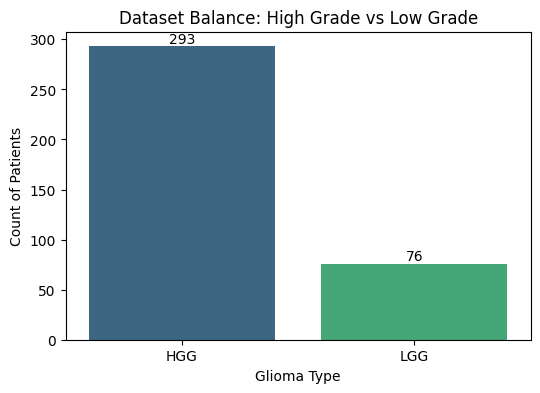


BALANCE RESULTS:
Grade
HGG    293
LGG     76
Name: count, dtype: int64


In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import os

print("\nCHECKING DATASET BALANCE (TRAINING SET ONLY)")

all_csvs = glob.glob("./brats2020/**/*.csv", recursive=True)
training_csv_candidates = [f for f in all_csvs if "Training" in f and "survival" not in f.lower()]

if training_csv_candidates:
    target_csv = training_csv_candidates[0]
    print(f"Reading metadata from: {target_csv}")

    df = pd.read_csv(target_csv)

    print(f"Columns found: {df.columns.tolist()}")
    if 'Grade' in df.columns:
        grade_col = 'Grade'
    elif 'grade' in df.columns:
        grade_col = 'grade'
    else:
        grade_col = None

    if grade_col:
        plt.figure(figsize=(6, 4))
        ax = sns.countplot(x=grade_col, data=df, palette='viridis')
        plt.title("Dataset Balance: High Grade vs Low Grade")
        plt.xlabel("Glioma Type")
        plt.ylabel("Count of Patients")

        for p in ax.patches:
             ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', xytext=(0, 5), textcoords='offset points')
        plt.show()

        counts = df[grade_col].value_counts()
        print(f"\nBALANCE RESULTS:\n{counts}")
    else:
        print("'Grade' column missing in Training CSV.")
        print("Checking if HGG/LGG info is embedded in folder structure...")

        hgg_folders = glob.glob("./brats2020/**/HGG", recursive=True)
        lgg_folders = glob.glob("./brats2020/**/LGG", recursive=True)

        if hgg_folders or lgg_folders:
            n_hgg = len(os.listdir(hgg_folders[0])) if hgg_folders else 0
            n_lgg = len(os.listdir(lgg_folders[0])) if lgg_folders else 0
            print(f"Found via folders: HGG={n_hgg}, LGG={n_lgg}")
        else:
            print("Could not determine Balance. (This is common if you are using the simplified BraTS 2020 version where classes are merged).")
            print("Assuming standard split: ~293 HGG / ~76 LGG (Typical for BraTS 2020)")

else:
    print("No Training CSV found. Make sure you have downloaded 'MICCAI_BraTS2020_TrainingData'.")

RUNNING ADVANCED EDA ON 50 PATIENTS
Processed 0/50...
Processed 10/50...
Processed 20/50...
Processed 30/50...
Processed 40/50...


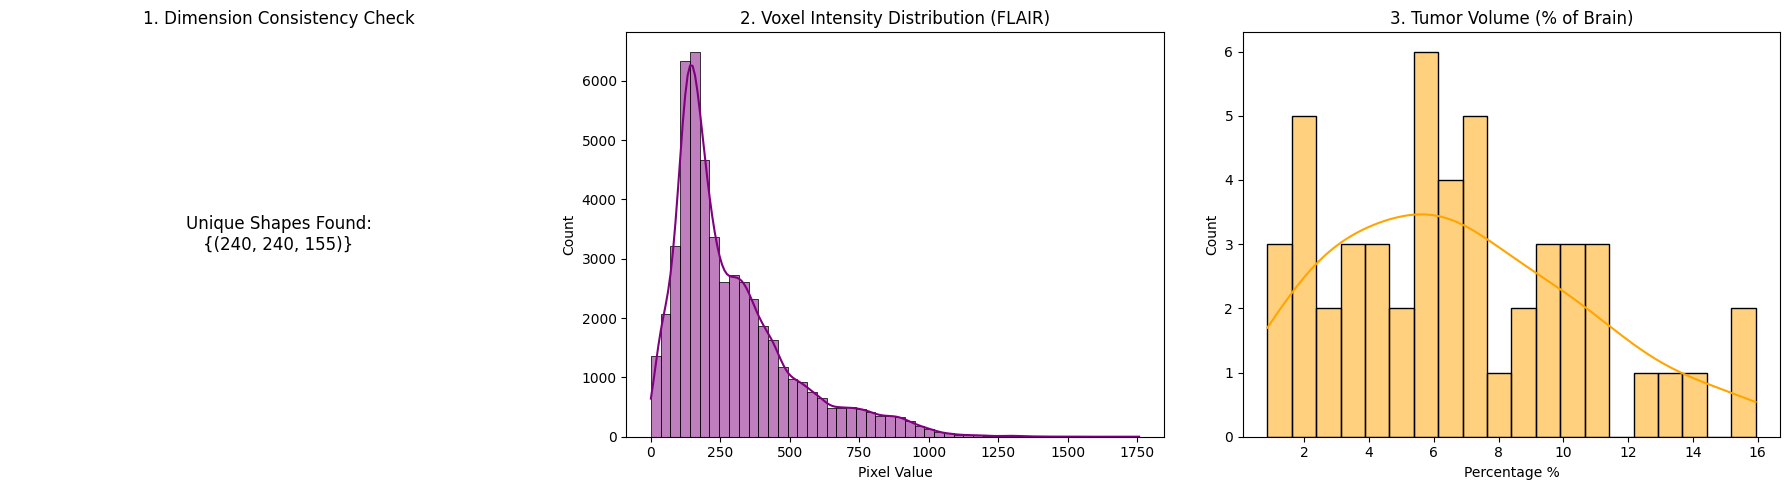

Most Common Shape: (240, 240, 155)
Average Tumor Size: 6.75% of the brain


In [12]:
import nibabel as nib
import numpy as np

SAMPLE_SIZE = 50
root_search = glob.glob("./brats2020/**/MICCAI_BraTS2020_TrainingData", recursive=True)
data_root = root_search[0] if root_search else "./brats2020"
patient_dirs = sorted([d for d in glob.glob(os.path.join(data_root, "*")) if os.path.isdir(d)])

valid_patients = []
for p in patient_dirs:
    if glob.glob(os.path.join(p, "*flair.nii")) and glob.glob(os.path.join(p, "*seg.nii")):
        valid_patients.append(p)

sampled_patients = random.sample(valid_patients, min(SAMPLE_SIZE, len(valid_patients)))

print(f"RUNNING ADVANCED EDA ON {len(sampled_patients)} PATIENTS")

dimensions = []
intensities = []
tumor_volumes = [] # Percentage of brain that is tumor

for i, p_dir in enumerate(sampled_patients):
    flair_path = glob.glob(os.path.join(p_dir, "*flair.nii"))[0]
    seg_path = glob.glob(os.path.join(p_dir, "*seg.nii"))[0]

    flair = nib.load(flair_path).get_fdata()
    seg = nib.load(seg_path).get_fdata()

    dimensions.append(flair.shape)

    brain_pixels = flair[flair > 0]
    if len(brain_pixels) > 0:
        intensities.extend(np.random.choice(brain_pixels, 1000))

    tumor_pixels = np.sum(seg > 0)
    total_brain_pixels = np.sum(flair > 0)

    if total_brain_pixels > 0:
        ratio = (tumor_pixels / total_brain_pixels) * 100
        tumor_volumes.append(ratio)

    if i % 10 == 0:
        print(f"Processed {i}/{len(sampled_patients)}...")

plt.figure(figsize=(18, 5))

# Plot 1: Dimensions
unique_dims = set(dimensions)
plt.subplot(1, 3, 1)
plt.text(0.5, 0.5, f"Unique Shapes Found:\n{unique_dims}",
         fontsize=12, ha='center', va='center', wrap=True)
plt.title("1. Dimension Consistency Check")
plt.axis('off')

# Plot 2: Intensity Histogram
plt.subplot(1, 3, 2)
sns.histplot(intensities, bins=50, color='purple', kde=True)
plt.title("2. Voxel Intensity Distribution (FLAIR)")
plt.xlabel("Pixel Value")

# Plot 3: Tumor Size Distribution
plt.subplot(1, 3, 3)
sns.histplot(tumor_volumes, bins=20, color='orange', kde=True)
plt.title("3. Tumor Volume (% of Brain)")
plt.xlabel("Percentage %")

plt.tight_layout()
plt.show()

print(f"Most Common Shape: {dimensions[0]}")
print(f"Average Tumor Size: {np.mean(tumor_volumes):.2f}% of the brain")
if np.mean(tumor_volumes) < 1.0:
    print("WARNING: Tumors are very small! 'Class Imbalance' handling is required.")